### Sensitivity : watermass boundary
Determine the sensitivity of the calculation of UCDW destruction time-series to the watermass boundary

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import xarray as xr
import so_decadal_variability as so
import matplotlib.pyplot as plt
import numpy as np
import utils.operations as op

In [2]:
rootdir = '../../data/processed/ECCO/'
filename_all = 'binned_vol_budget_month_dGamman_0.02_BF_G.nc'
filename_bowl = 'binned_vol_budget_month_dGamman_0.02_bowl_p2_BF_G.nc'
ds_all = xr.open_dataset(rootdir+filename_all).isel(gamma_n=slice(1,-1))
ds_bowl = xr.open_dataset(rootdir+filename_bowl).isel(gamma_n=slice(1,-1))

In [47]:
# Only retain non-zero values
# (This relies on the fact that nowhere else is exactly zero)
ds_all = ds_all.where(ds_all['bin_ADV']!=0,drop=True)
ds_bowl = ds_bowl.where(ds_bowl['bin_ADV']!=0,drop=True)
terms = ['bin_ADV','bin_DIF','bin_FORC','bin_TEN']
colors = {'bin_ADV':'tab:blue','bin_DIF':'tab:orange','bin_FORC':'tab:green','bin_TEN':'tab:red'}

#### Get boundaries from smoothed advection

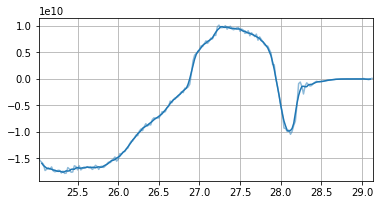

In [48]:
X = ds_all['bin_ADV'].mean('time')
Xsmooth = X.rolling({'gamma_n':5},center=True).mean()
fig,ax=plt.subplots(figsize=(6,3))
ax.plot(X['gamma_n'],X,alpha=0.5)
ax.plot(X['gamma_n'],Xsmooth,color='tab:blue')
ax.grid()
ax.autoscale(enable=True, axis='x', tight=True)

In [49]:
# Find the crossing points of the time-mean advection
c = op.crossing(Xsmooth,'gamma_n')
ex = op.extrema(Xsmooth,'gamma_n',order=10)
# List and sort them
bounds = np.sort(np.concatenate((c.values, ex['min'].values, ex['max'].values)))
bounds

array([25.32, 26.88, 27.28, 27.96, 28.1 ])

In [50]:
ucdw_l = 27.28
ucdw_u = 27.96
dr = 0.1
ucdw_l_r = np.linspace(ucdw_l-dr/2,ucdw_l+dr/2,10)
ucdw_u_r = np.linspace(ucdw_u-dr/2,ucdw_u+dr/2,10)

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


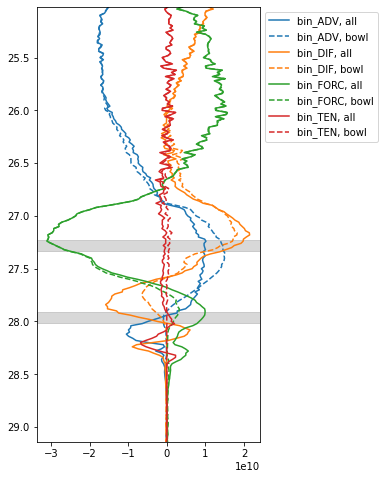

In [52]:
# Plot transformation, with watermasses
fig,ax = plt.subplots(figsize=(4,8))
for term in terms:
    ax.plot(ds_all[term].mean('time'),ds_all['gamma_n'],
            label=term+', all',color=colors[term])
    ax.plot(ds_bowl[term].mean('time'),ds_bowl['gamma_n'],
            label=term+', bowl',color=colors[term],linestyle='--')
ax.invert_yaxis()
ax.autoscale(enable=True, axis='y', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
xlim = ax.get_xlim()
p = plt.Rectangle((xlim[0],ucdw_l_r[0]),np.diff(xlim),dr,color='gray',alpha=0.3)
ax.add_patch(p)
p = plt.Rectangle((xlim[0],ucdw_u_r[0]),np.diff(xlim),dr,color='gray',alpha=0.3)
ax.add_patch(p)
# for b in np.array([ucdw_l-dr/2bounds:
#     ax.plot(xlim,(b, b),'k')
# ax.autoscale(enable=True, axis='x', tight=True)

#### Calculate formation

In [35]:
# Calculate formation
formation_all = -1*ds_all.diff('gamma_n')
formation_bowl = -1*ds_bowl.diff('gamma_n')

#### Integrate within UCDW bin

In [36]:
wmf_all = formation_all.sel({'gamma_n':slice(ucdw_l,ucdw_u)}).sum('gamma_n')
wmf_bowl = formation_bowl.sel({'gamma_n':slice(ucdw_l,ucdw_u)}).sum('gamma_n')
wmf_int = wmf_all - wmf_bowl

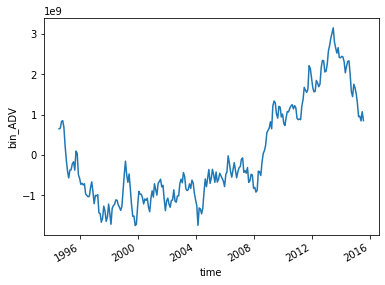

In [37]:
so.calc._anom(wmf_all['bin_ADV'].rolling(time=60,center=True).mean()).plot()

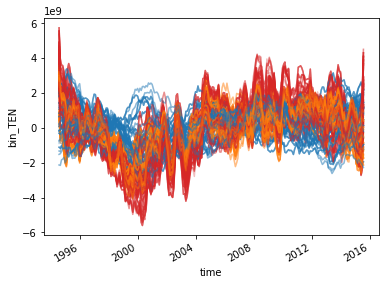

In [55]:
for l in ucdw_l_r:
    for u in ucdw_u_r:
        wmf = formation_all.sel({'gamma_n':slice(l,u)}).sum('gamma_n')
        wmf['bin_FORCDIF'] = wmf['bin_FORC']+wmf['bin_DIF']
        so.calc._anom(
            wmf['bin_ADV'].rolling(time=60,center=True).mean()
        ).plot(color='tab:blue',alpha=0.3)
        so.calc._anom(
            wmf['bin_FORCDIF'].rolling(time=60,center=True).mean()
        ).plot(color='tab:orange',alpha=0.3)
        so.calc._anom(
            wmf['bin_TEN'].rolling(time=60,center=True).mean()
        ).plot(color='tab:red',alpha=0.3)